Download the necessary libraries & import data.

In [15]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD

from sklearn.decomposition import FastICA, NMF, KernelPCA, PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import SpectralEmbedding
import seaborn as sns
import umap

from adjustText import adjust_text

In [16]:
df = pd.read_csv('authors.csv').rename(columns = {'Unnamed: 0': 'Author'})
X = df.copy().drop(['Author','BookID'], axis=1)


In [17]:
X_transpose = X.T
X_transpose = X_transpose.rename(columns = {i:f'Chapter{i}' for i in range(X_transpose.shape[1])})
X_transpose

,Chapter0,Chapter1,Chapter2,Chapter3,Chapter4,Chapter5,Chapter6,Chapter7,Chapter8,Chapter9,...,Chapter831,Chapter832,Chapter833,Chapter834,Chapter835,Chapter836,Chapter837,Chapter838,Chapter839,Chapter840
a,46,35,46,40,29,27,34,38,34,54,...,46,48,39,22,28,32,16,22,25,26
all,12,10,2,7,5,8,8,6,12,8,...,4,2,5,13,7,4,5,15,4,4
also,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
an,3,7,3,4,6,3,15,2,5,6,...,3,9,10,5,7,6,5,3,8,2
and,66,44,40,64,52,42,44,67,50,44,...,43,45,38,47,45,33,49,48,59,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
who,8,3,4,5,2,6,4,6,1,3,...,1,0,2,4,2,3,0,0,2,3
will,4,5,5,3,4,3,9,7,2,5,...,7,10,8,9,7,11,11,12,22,11
with,9,14,15,22,21,18,11,15,13,15,...,18,11,26,12,8,17,20,15,23,19
would,1,8,3,4,10,4,6,3,12,6,...,2,6,2,6,3,5,2,1,4,0


In [18]:
# Add a small constant to avoid zeros (NMF needs non-negative data)
X_nmf = X_transpose + 1e-6

# Run NMF with k topics
k = 4
model = NMF(n_components=k, init='random', random_state=0, max_iter=500)
W = model.fit_transform(X_nmf)  # shape: (69 words, k topics)
H = model.components_           # shape: (k topics, 841 chapters)

# Turn W into a DataFrame with word labels
W_df = pd.DataFrame(W, index=X_transpose.index, columns=[f'Topic{i+1}' for i in range(k)])
W_df

,Topic1,Topic2,Topic3,Topic4
a,12.703487,9.567095,0.483944,2.602374
all,1.079770,1.396586,2.248865,1.258959
also,0.229118,0.000000,0.144176,0.000000
an,4.549360,1.441845,0.000000,0.054374
and,9.307504,5.728211,17.722282,6.001697
...,...,...,...,...
who,0.059405,0.297646,1.169796,0.495165
will,0.000000,3.631641,0.258497,0.254086
with,0.746218,2.372410,4.244667,2.023698
would,0.484461,1.523643,0.000000,1.441098


In [19]:
# NOW LETS INTERPRET OUR TOPICS
top_words_per_topic = {}
n = 10
for topic in W_df.columns:
    top_words = W_df[topic].sort_values(ascending=False).head(n)
    top_words_per_topic[topic] = top_words.index.tolist()

summary_df = pd.DataFrame(top_words_per_topic)
summary_df #importance in ascending order!

,Topic1,Topic2,Topic3,Topic4
0,the,the,and,to
1,was,a,the,her
2,of,to,of,and
3,a,my,to,of
4,and,is,his,was
5,in.,of,in.,be
6,it,it,with,not
7,had,that,from,had
8,that,not,all,as
9,an,and,their,it


Topic 1 = Narritive/Descriptive (past tense)

Topic 2 = Reflective/Personal voice

Topic 3 = Relational

Topic 4 = Dialogue/Character-driven phrasing

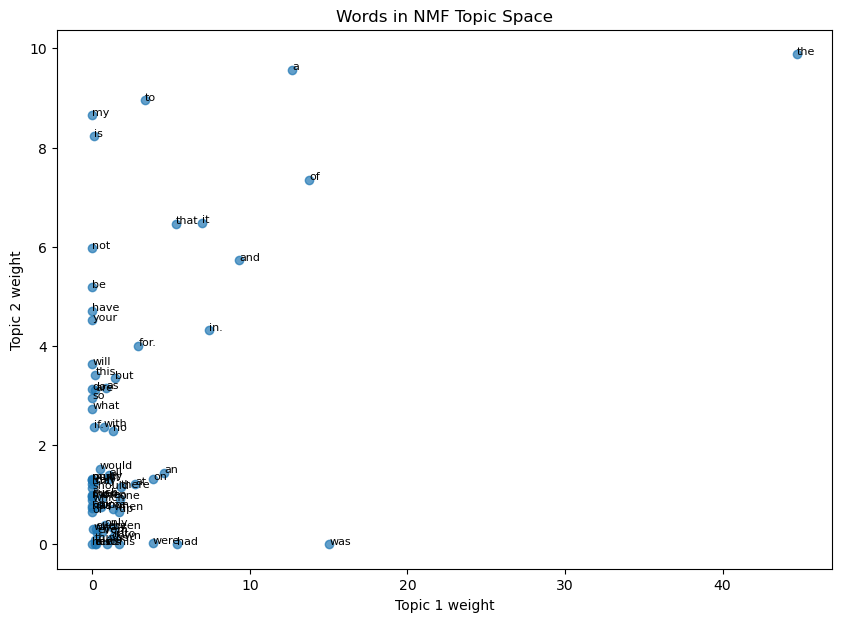

In [20]:
plt.figure(figsize=(10, 7))
plt.scatter(W[:, 0], W[:, 1], alpha=0.7)

for i, word in enumerate(X_transpose.index):
    plt.text(W[i, 0], W[i, 1], word, fontsize=8)

plt.xlabel("Topic 1 weight")
plt.ylabel("Topic 2 weight")
plt.title("Words in NMF Topic Space")
plt.show()

This is hard to read so we will take out a lot of the insignificant words and replot.

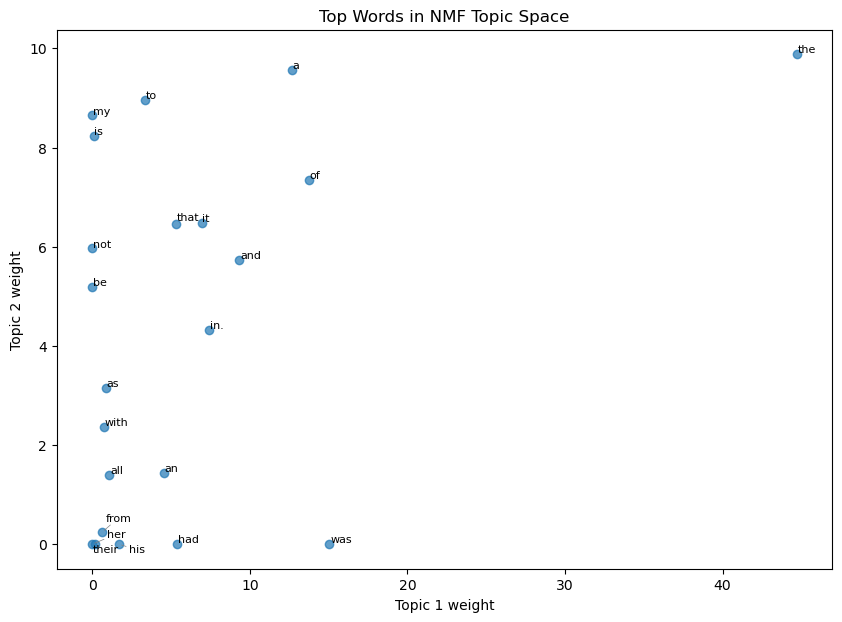

In [21]:
top_n = n
top_words = set()
for topic in W_df.columns:
    top_words.update(W_df[topic].sort_values(ascending=False).head(top_n).index)
W_top = W_df.loc[list(top_words)] # Filter W to only top words

plt.figure(figsize=(10, 7))
plt.scatter(W_top.iloc[:, 0], W_top.iloc[:, 1], alpha=0.7)

texts = []
for i, word in enumerate(W_top.index):
    texts.append(plt.text(W_top.iloc[i, 0], W_top.iloc[i, 1], word, fontsize=8))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
plt.xlabel("Topic 1 weight")
plt.ylabel("Topic 2 weight")
plt.title("Top Words in NMF Topic Space")
plt.show()
